# Hausarbeit im Seminar Textanalyse WiSe 22/23
## Research Question

Wo sind die Parteien der UNi Wahlen in Göttingen im Vergleich zu Bundestagsparteien auf einer Links-Rechts Skala einzuordnen?

## Vorbereitung
Zunächst werden die Parteien definieiert und die Wahlprogramme (soweit vorhanden) eingelsen.

In [1]:
# import modules
import pandas as pd
from nltk.corpus import stopwords
import spacy
from wordscores3 import Wordscores
import matplotlib.pyplot as plt

In [2]:
PARTIES = [
    "ALL_BB",
    "GDF",
    "GHG",
    "JUSO",
    "LHG",
    "LISTE_VOLT",
    "NORDCAMPUS",
    "RCDS"
]

PROGRAMS = {}

for party in PARTIES:
    with open(f"{party}.txt", "r", encoding="utf-8") as f:
        file_content = f.read()
        PROGRAMS[party] = file_content

df = pd.DataFrame(PROGRAMS.items(), columns=["party", "program"])

# MARPOR data for reference texts
BUND_PARTIES = ["CDU", "FDP", "Grüne", "SPD", "AfD", "Linke"]
for party_name in BUND_PARTIES:
    new_df = pd.read_csv(f"{party_name}2021.csv")
    text = " ".join(new_df.text)
    new_row = [party_name, text]
    df.loc[len(df)] = new_row



df

,party,program
0,ALL_BB,"test test test Email sent, waiting for response"
1,GDF,Hochschulpolitik - Nicht mehr und nicht wenige...
2,GHG,"Liebe Studis, \nEs ist wieder so weit, die Hoc..."
3,JUSO,"Liebe Wähler*innen,\nvor euch seht ihr unser W..."
4,LHG,AStA-Beiträge senken\nAllgemeine Studiengebühr...
5,LISTE_VOLT,"Volt & Die LISTE verstehen sich als linkes, pr..."
6,NORDCAMPUS,Mehr interdisziplinäre Zusammenarbeit\nViele S...
7,RCDS,Auslandsstudium\nWer ein Semester im Ausland v...
8,CDU,Das Programm für Stabilität und Erneuerung. GE...
9,FDP,Nie gab es mehr zu tun Wahlprogramm der Freien...


## Data Cleaning
Im nächsten Schritt werden die Wahlprogramme gereinigt. Das Bedeutet, dass einige, für die Analyse unwichtige oder störende, Elemente gelöscht werden. Darunter zählen:
- Zeilenumbrüche
- großbuchstaben (werden klein geschrieben)
- anderes

In [3]:
# stopwords definieren
custom_stopwords = ["test"]
stopwords_used = stopwords.words("german") + custom_stopwords

# lemmatization setup
nlp = spacy.load('de_core_news_sm')


for i, prog in df.program.items():
    print(f"Current: {i+1}/{len(df.program)}...")
    # lemma
    nlp_doc = nlp(prog)
    lemma_list = [x.lemma_ for x in nlp_doc]

    # remove stopwords and lower
    no_stopwords = [word.lower() for word in lemma_list if word.lower() not in stopwords_used]

    # remove short tokens
    min_len = 3
    new_list = [word for word in no_stopwords if len(word) >= min_len]


    # save to df
    df.program[i] = new_list


df.program

Current: 1/14...
Current: 2/14...
Current: 3/14...
Current: 4/14...
Current: 5/14...
Current: 6/14...
Current: 7/14...
Current: 8/14...
Current: 9/14...
Current: 10/14...
Current: 11/14...
Current: 12/14...
Current: 13/14...
Current: 14/14...


0                [email, senen, waiting, for, response]
1     [hochschulpolitik, mehr, weniger, hochschulpol...
2     [liebe, studi, weit, hochschulwahle, stehen, 1...
3     [lieb, wähler*innen, sehen, wahlprogramm, hoch...
4     [asta-beitrag, senken, allgemein, studiengebüh...
5     [volt, liste, verstehen, linkes, progressiv, q...
6     [mehr, interdisziplinär, zusammenarbeit, viele...
7     [auslandsstudium, wer, semester, ausland, verb...
8     [programm, stabilität, erneuerung, gemeinsam, ...
9     [nie, geben, mehr, tun, wahlprogramm, frei, de...
10    [deutschland, drin, bundestagswahlprogramm, 20...
11    [respekt, zukunft, zukunftsprogramm, spd, wofü...
12    [deutschland, normal, programm, alternative, f...
13    [zeit, handeln, sozial, sicherheit, frieden, k...
Name: program, dtype: object

## Wordscores berechnen
Basierend auf [Arbeit von Thiago Marzagao](https://thiagomarzagao.com/2013/06/10/wordscores-in-python/) und angepasst für python 3

In [4]:
def create_word_frequency_matrix(index: int) -> pd.DataFrame:
    absolute_freq = pd.Series(df.program[index]).value_counts()
    relative_freq = pd.Series(df.program[index]).value_counts(normalize=True)
    word_freq_df = pd.DataFrame({
        "abs_freq": absolute_freq,
        "rel_freq": relative_freq
    })

    return(word_freq_df)

for i in range(len(df)):
    create_word_frequency_matrix(i).to_csv(f"inputdata/{df.party[i]}.csv", header=False)



In [5]:
MARPOR_RILE_2021 = {
    "GRÜNE": -21.038,
    "LINKE": -36.167,
    "SPD": -24.673,
    "FDP": 0.266,
    "CDU": 3.495,
    "AFD": 26.048
}

A_r = pd.DataFrame({'LINKE': MARPOR_RILE_2021["LINKE"],
                   'AFD': MARPOR_RILE_2021["AFD"],
                   "Linke": MARPOR_RILE_2021["LINKE"],
                   "SPD": MARPOR_RILE_2021["SPD"],
                   "FDP": MARPOR_RILE_2021["FDP"],
                   "CDU": MARPOR_RILE_2021["CDU"],
                   "Grüne": MARPOR_RILE_2021["GRÜNE"]},
                   index = ['score'])

W = Wordscores(A_r=A_r)

results_rile = W.run()[1:]
print(results_rile)

# ohne transformation:
#                 score
# GDF        -10.750870
# GHG        -11.605535
# JUSO       -11.829653
# LHG         -8.615741
# LISTE_VOLT -11.951862
# NORDCAMPUS -11.215008
# RCDS        -8.869562

c:\Users\User\Desktop\Uni\WiSe 22-23\Empirische Demokratieforschung\Seminar_Methoden_der_Analyse_politischer_Texte_und_ihre_Anwendung\python_code\hausarbeit\wordscores3.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.P_wr = self.F_wr.iloc[:, 1:].div(self.F_wr.sum(axis = 1), axis = 0)


                score
GDF        -17.604873
GHG        -23.568569
JUSO       -25.132420
LHG         -2.706329
LISTE_VOLT -25.985172
NORDCAMPUS -20.843544
RCDS        -4.477446


## Positive Stellung zu Immigration als proxy für Kulturelle Dimension?
MARPOR 602.2 Werte


In [6]:
MARPOR_IM_POS_2021 = { # MARPOR 602.2
    "GRÜNE": 0.886,
    "LINKE": 0.391,
    "SPD": 0.654,
    "FDP": 0.62,
    "CDU": 0.685,
    "AFD": 0
}

A_r = pd.DataFrame({'LINKE': MARPOR_IM_POS_2021["LINKE"],
                   'AFD': MARPOR_IM_POS_2021["AFD"],
                   "Linke": MARPOR_IM_POS_2021["LINKE"],
                   "SPD": MARPOR_IM_POS_2021["SPD"],
                   "FDP": MARPOR_IM_POS_2021["FDP"],
                   "CDU": MARPOR_IM_POS_2021["CDU"],
                   "Grüne": MARPOR_IM_POS_2021["GRÜNE"]},
                   index = ['score'])

W = Wordscores(A_r=A_r)

results_im_pos = W.run()[1:]
print(results_im_pos)

# ohne transformation:
#                score
# GDF         0.412069
# GHG         0.420841
# JUSO        0.447858
# LHG         0.391540
# LISTE_VOLT  0.445551
# NORDCAMPUS  0.435666
# RCDS        0.425437

c:\Users\User\Desktop\Uni\WiSe 22-23\Empirische Demokratieforschung\Seminar_Methoden_der_Analyse_politischer_Texte_und_ihre_Anwendung\python_code\hausarbeit\wordscores3.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.P_wr = self.F_wr.iloc[:, 1:].div(self.F_wr.sum(axis = 1), axis = 0)


               score
GDF         0.451185
GHG         0.471391
JUSO        0.533623
LHG         0.403898
LISTE_VOLT  0.528309
NORDCAMPUS  0.505539
RCDS        0.481976


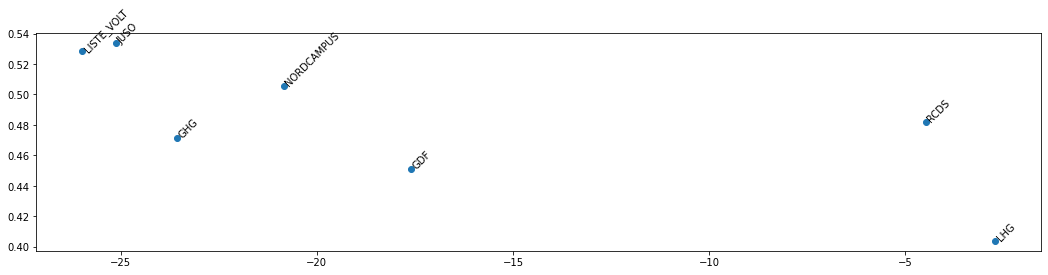

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)

x = results_rile.score
y = results_im_pos.score
ax.scatter(x, y)
txt = results_rile.index
for i, txt in enumerate(txt):
    ax.annotate(txt, (x[i], y[i]), rotation=45)

# ax.axis("off")
plt.show()

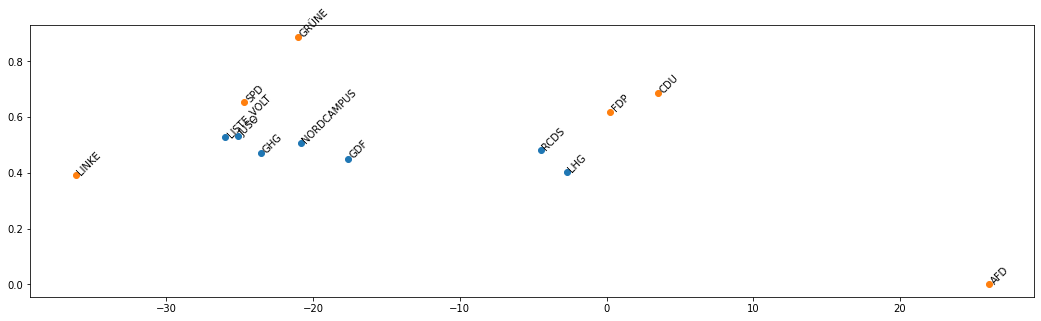

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 5)

x = results_rile.score
y = results_im_pos.score
ax.scatter(x, y)
txt = results_rile.index
for i, txt in enumerate(txt):
    ax.annotate(txt, (x[i], y[i]), rotation=45)

# add bundestag parties
p_names = MARPOR_RILE_2021.keys()
x_bund = [MARPOR_RILE_2021[p_name] for p_name in p_names]
y_bund = [MARPOR_IM_POS_2021[p_name] for p_name in p_names]
ax.scatter(x_bund, y_bund)


for i, p_name in enumerate(p_names):
    ax.annotate(p_name, (x_bund[i], y_bund[i]), rotation=45)

# ax.axis("off")
plt.show()

## Weitere Ideen:
- Textskalierungsverfahren für explorativere analyse
- Wordfish, wahrscheinlich wenig sinnvoll wegen lantenter dimension ohne vergleichswert für Uni-Wahlen